In [1]:
from tensorflow.keras import datasets, layers, models
import numpy as np
import tensorflow.keras.backend as K

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

The fashion mnist dataset contains 28 x 28 images 

In [3]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [4]:
def preprocess(image):
    """Normalize the images"""
    image = image.astype('float32') / 255.0
    image = np.pad(image, ((0,0), (2,2), (2,2)), constant_values=0.0)
    image = np.expand_dims(image, -1)
    return image

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [5]:
x_train[0].shape

(32, 32, 1)

Encoder Layer

In [14]:
encoder_input = layers.Input(shape=(32,32 ,1), name="encoder_input")
x = layers.Conv2D(filters = 32, kernel_size=(3,3), strides = 2, activation = "relu", padding="same" )(encoder_input)
x = layers.Conv2D(filters = 64, kernel_size= (3,3), strides = 2, activation = "relu", padding="same")(x)
x = layers.Conv2D(filters = 128, kernel_size = (3, 3), strides= 2 , activation = "relu", padding = "same")(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name="encoder_output")(x)
encoder = models.Model(encoder_input, encoder_output)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable

In [15]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable

Decoder

In [8]:
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="Same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3,3), strides =2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(1, (2,2), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)
decoder = models.Model(decoder_input, decoder_output)

In [9]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       1846

Autoencoder model


In [17]:
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
) 

In [18]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [20]:
autoencoder.fit(x_train,x_train,epochs=5,batch_size=100,shuffle=True, validation_data=(x_test, x_test))

Epoch 1/5
600/600 [==============================] - 12s 21ms/step - loss: 0.2510 - val_loss: 0.2535
Epoch 2/5
600/600 [==============================] - 12s 21ms/step - loss: 0.2503 - val_loss: 0.2514
Epoch 3/5
600/600 [==============================] - 12s 21ms/step - loss: 0.2495 - val_loss: 0.2509
Epoch 4/5
600/600 [==============================] - 12s 20ms/step - loss: 0.2488 - val_loss: 0.2506
Epoch 5/5
600/600 [==============================] - 13s 21ms/step - loss: 0.2482 - val_loss: 0.2501


In [21]:
example_image = x_test[:5000]
predictions = autoencoder.predict(example_image)

157/157 [==============================] - 1s 5ms/step


In [24]:
embeddings = encoder.predict(example_image)

157/157 [==============================] - 0s 3ms/step


In [25]:
import matplotlib.pyplot as plt

In [27]:
embeddings

array([[-4.140907  , -3.4274657 ],
       [ 1.1554222 ,  0.6468719 ],
       [-2.9497664 , 17.340763  ],
       ...,
       [ 0.6945242 , -3.0778482 ],
       [-0.03111063,  5.7476106 ],
       [-9.108939  , -2.3480291 ]], dtype=float32)

In [35]:
val = np.arange(0,10)

In [36]:
val

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [39]:
labels = y_test[:5000]

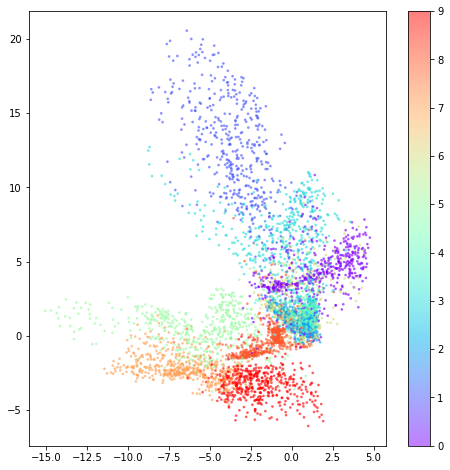

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(embeddings[:, 0], embeddings[:,1], cmap = "rainbow", c = labels, alpha=0.5, s=3)
plt.colorbar()
plt.show()

Generating New Images

In [44]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, 2)
)
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 350ms/step


In [48]:
reconstructions[0].shape

(32, 32, 1)

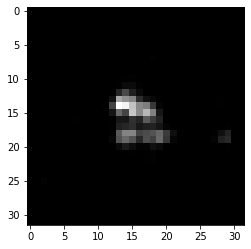

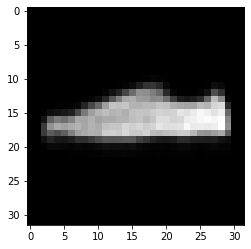

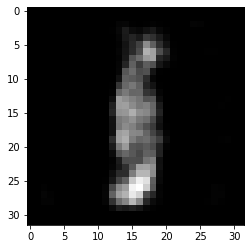

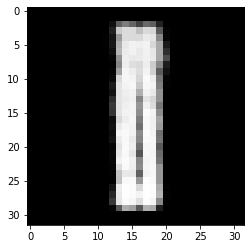

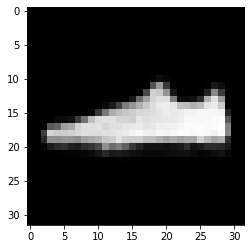

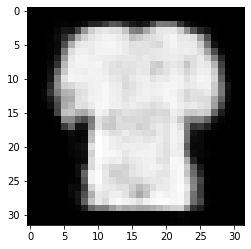

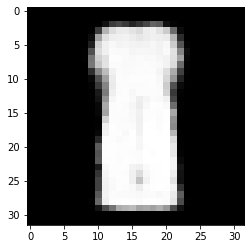

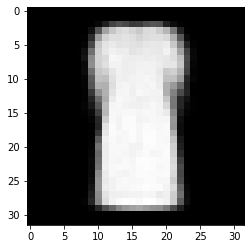

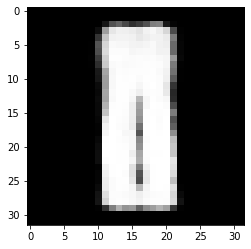

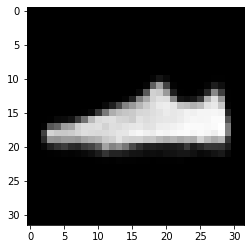

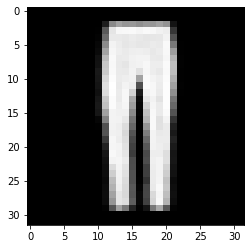

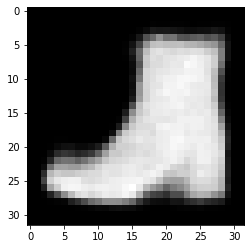

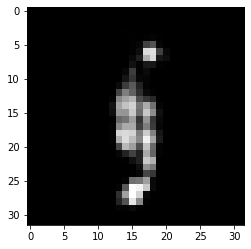

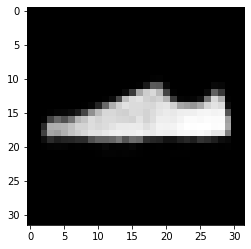

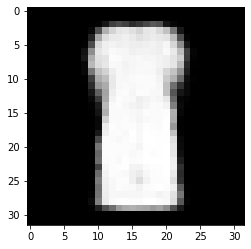

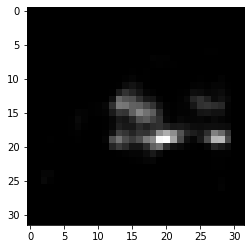

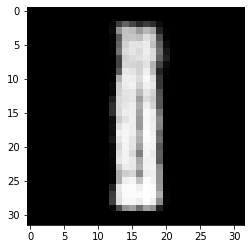

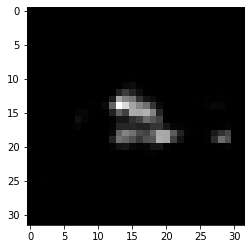

In [51]:
for i in reconstructions:
    plt.imshow(i, cmap="gray")
    plt.show()